In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Cas9/On target')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from operator import add
from functools import reduce

from keras import Model
from keras import regularizers
from keras.optimizers import Adam
from keras.layers import Conv2D, BatchNormalization, ReLU, Input, Flatten, Softmax
from keras.layers import Concatenate, Activation, Dense, GlobalAveragePooling2D, Dropout
from keras.layers import AveragePooling1D, Bidirectional, LSTM, GlobalAveragePooling1D, MaxPool1D, Reshape
from keras.layers import LayerNormalization, Conv1D, MultiHeadAttention, Layer, SimpleRNN
from keras.models import load_model
from keras.metrics import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold

from sklearn.model_selection import KFold
import matplotlib

!pip install GPyOpt
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.5 MB/s eta 0:00:00
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=12969322ed70a3592626164e9353d0a88b1076bb97e2807d20d7a1d1f39bba05
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
Successfully built GPyOpt


In [5]:
import keras
import tensorflow
print(python.__version__)

2.15.0


### Data preparation

In [ ]:
def PREPROCESS(lines):
    data_n = len(lines) - 1
    SEQ = np.zeros((data_n, 23, 4), dtype=int)
    label = np.zeros((data_n, 1, 1))

    for l in range(1, data_n + 1):
        data = lines[l].split(',')

        y = float(data[2])
        if y < 0:
            label[l - 1, 0, 0] = 0
        else:
            label[l - 1, 0, 0] = y

        seq = data[1]
        for i in range(23):
            if seq[i] in "Aa":
                SEQ[l - 1, i, 0] = 1
            elif seq[i] in "Cc":
                SEQ[l - 1, i, 1] = 1
            elif seq[i] in "Gg":
                SEQ[l - 1, i, 2] = 1
            elif seq[i] in "Tt":
                SEQ[l - 1, i, 3] = 1

    return SEQ, label

In [ ]:
FILE = open('/content/drive/MyDrive/Colab Notebooks/Cas9/On target/data/Kim2019_train.csv', "r")
data = FILE.readlines()
Seq, label = PREPROCESS(data)
FILE.close()

### Hyperparameter optimization for Transformer model

In [ ]:
class PositionalEncoding(Layer):
    def __init__(self, sequence_len=None, embedding_dim=None,**kwargs):
        super(PositionalEncoding, self).__init__()
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim

    def call(self, x):

        position_embedding = np.array([
            [pos / np.power(10000, 2. * i / self.embedding_dim) for i in range(self.embedding_dim)]
            for pos in range(self.sequence_len)])

        position_embedding[:, 0::2] = np.sin(position_embedding[:, 0::2])  # dim 2i
        position_embedding[:, 1::2] = np.cos(position_embedding[:, 1::2])  # dim 2i+1
        position_embedding = tf.cast(position_embedding, dtype=tf.float32)

        return position_embedding+x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'sequence_len' : self.sequence_len,
            'embedding_dim' : self.embedding_dim,
        })
        return config

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate):
        # embed_dim: Embedding size for each token
        # num_heads: Number of attention heads
        # ff_dim: Hidden layer size in feed forward network inside transformer

        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-3)
        self.layernorm2 = LayerNormalization(epsilon=1e-3)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def Transformer_model(input_shape, num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                      dropout_rate_dense, dropout_rate_transformer, lstm1_unit, lstm2_unit,
                      num_heads, ff_dim, dense1_unit, dense2_unit, dense3_unit):
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(num_filter, kernel_size, activation="relu")(inputs)
    pool1 = AveragePooling1D(2)(conv1)
    drop1 = Dropout(dropout_rate_conv)(pool1)

    conv2 = Conv1D(num_filter, kernel_size, activation="relu")(drop1)
    pool2 = AveragePooling1D(2)(conv2)
    drop2 = Dropout(dropout_rate_conv)(pool2)

    lstm1 = Bidirectional(LSTM(lstm1_unit,
                               dropout=dropout_rate_lstm,
                               activation='tanh',
                               return_sequences=True,
                               kernel_regularizer=regularizers.l2(1e-4)))(drop2)
    lstm2 = Bidirectional(LSTM(lstm2_unit,
                               dropout=dropout_rate_lstm,
                               activation='tanh',
                               return_sequences=True,
                               kernel_regularizer=regularizers.l2(1e-4)))(lstm1)

    pos_embedding = PositionalEncoding(sequence_len=int(((23-kernel_size+1)/2-kernel_size+1)/2), embedding_dim=2*lstm2_unit)(lstm2)
    trans = TransformerBlock(2*lstm2_unit, num_heads, ff_dim, dropout_rate_transformer)(pos_embedding)
    avgpool = GlobalAveragePooling1D()(trans)

    dense1 = Dense(dense1_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(avgpool)
    drop3 = Dropout(dropout_rate_dense)(dense1)

    dense2 = Dense(dense2_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop3)
    drop4 = Dropout(dropout_rate_dense)(dense2)

    dense3 = Dense(dense3_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop4)
    drop5 = Dropout(dropout_rate_dense)(dense3)

    output = Dense(1, activation="linear")(drop5)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [ ]:
def HPO_with_CV(args):
    learning_rate = args[0][0]
    batch_size = int(args[0][1])
    num_filter = int(args[0][2])
    kernel_size = int(args[0][3])
    dropout_rate_conv = args[0][4]
    dropout_rate_lstm = args[0][5]
    dropout_rate_dense = args[0][6]
    dropout_rate_transformer = args[0][7]
    lstm1_unit = int(args[0][8])
    lstm2_unit = int(args[0][9])
    num_heads = int(args[0][10])
    ff_dim = int(args[0][11])
    dense1_unit = int(args[0][12])
    dense2_unit = int(args[0][13])
    dense3_unit = int(args[0][14])

    k_folds = 10
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1234)
    #fold_no = 1

    loss_per_fold = []
    #print(f'learning_rate:{learning_rate}\tbatch_size:{batch_size}\tnum_filter:{num_filter}\tkernel_size:{kernel_size}\tdropout_rate:{dropout_rate}\tlstm_unit:{lstm_unit}\tembed_dim:{embed_dim}\tnum_heads:{num_heads}\tff_dim:{ff_dim}\tdense1_unit:{dense1_unit}\tdense2_unit:{dense2_unit}\tdense3_unit:{dense3_unit}')
    print('Start training...')

    for train_index, val_index in kfold.split(Seq):
        X_train, X_val = Seq[train_index], Seq[val_index]
        y_train, y_val = label[train_index], label[val_index]

        model = Transformer_model((23,4), num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                                  dropout_rate_dense, dropout_rate_transformer, lstm1_unit, lstm2_unit,
                                  num_heads, ff_dim, dense1_unit, dense2_unit, dense3_unit)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

        #print(f'Training for fold {fold_no} ...')
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr])

        scores = model.evaluate(X_val, y_val, verbose=0)
        loss_per_fold.append(scores[1])

        #fold_no += 1

    avg_mse = np.mean(loss_per_fold)
    print('Avg validation MSE:', avg_mse)
    return avg_mse


In [ ]:
lr_domain = [0.01, 0.001, 0.0001]
batch_domain = [32, 64, 128, 256, 512]
num_filter_domain = [64, 128, 256, 512]
kernel_size_domain = [3, 5]
dropout_conv_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_lstm_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_dense_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_transformer_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
lstm1_unit_domain = [4, 8, 16, 32, 64, 128]
lstm2_unit_domain = [4, 8, 16, 32, 64, 128]
num_heads_domain = [2, 4, 6]
ff_dim_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense1_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense2_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense3_domain = [4, 8, 16, 32, 64, 128, 256, 512]

domain = [
    {"name": "learning_rate", "type": "discrete", "domain": lr_domain},
    {"name": "batch_size", "type": "discrete", "domain": batch_domain},
    {"name": "num_filter", "type": "discrete", "domain": num_filter_domain},
    {"name": "kernel_size", "type": "discrete", "domain": kernel_size_domain},
    {"name": "dropout_rate_conv", "type": "discrete", "domain": dropout_conv_domain},
    {"name": "dropout_rate_lstm", "type": "discrete", "domain": dropout_lstm_domain},
    {"name": "dropout_rate_dense", "type": "discrete", "domain": dropout_dense_domain},
    {"name": "dropout_rate_transformer", "type": "discrete", "domain": dropout_transformer_domain},
    {"name": "lstm1_unit", "type": "discrete", "domain": lstm1_unit_domain},
    {"name": "lstm2_unit", "type": "discrete", "domain": lstm2_unit_domain},
    {"name": "num_heads", "type": "discrete", "domain": num_heads_domain},
    {"name": "ff_dim", "type": "discrete", "domain": ff_dim_domain},
    {"name": "dense1_domain", "type": "discrete", "domain": dense1_domain},
    {"name": "dense2_domain", "type": "discrete", "domain": dense2_domain},
    {"name": "dense3_domain", "type": "discrete", "domain": dense3_domain}
]

In [ ]:
# Initialize Bayesian optimization
b_optimization = BayesianOptimization(
    HPO_with_CV,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    verbosity=True,
    num_cores=32
)

# Run optimization
b_optimization.run_optimization(max_iter=30)

Start training...
Avg validation MSE: 282.48155212402344
Start training...
Avg validation MSE: 266.75500946044923
Start training...
Avg validation MSE: 527.7988586425781
Start training...
Avg validation MSE: 264.0111907958984
Start training...
Avg validation MSE: 514.2231750488281
Start training...
Avg validation MSE: 268.53707733154295
Start training...
Avg validation MSE: 231.57721710205078
Start training...
Avg validation MSE: 536.7142639160156
Start training...
Avg validation MSE: 517.0503662109375
Start training...
Avg validation MSE: 509.71571044921876
Start training...
Avg validation MSE: 347.538525390625
Start training...
Avg validation MSE: 481.0494781494141
Start training...
Avg validation MSE: 243.3672119140625
Start training...
Avg validation MSE: 587.0024444580079
Start training...
Avg validation MSE: 329.2278564453125
Start training...
Avg validation MSE: 400.9602783203125
Start training...
Avg validation MSE: 553.7131439208985
Start training...
Avg validation MSE: 527.86

In [ ]:
b_optimization.x_opt, b_optimization.fx_opt

(array([1.00e-03, 6.40e+01, 5.12e+02, 3.00e+00, 1.00e-01, 5.00e-01,
        1.00e-01, 1.00e-01, 1.60e+01, 1.60e+01, 6.00e+00, 1.28e+02,
        5.12e+02, 6.40e+01, 1.60e+01]),
 231.57721710205078)

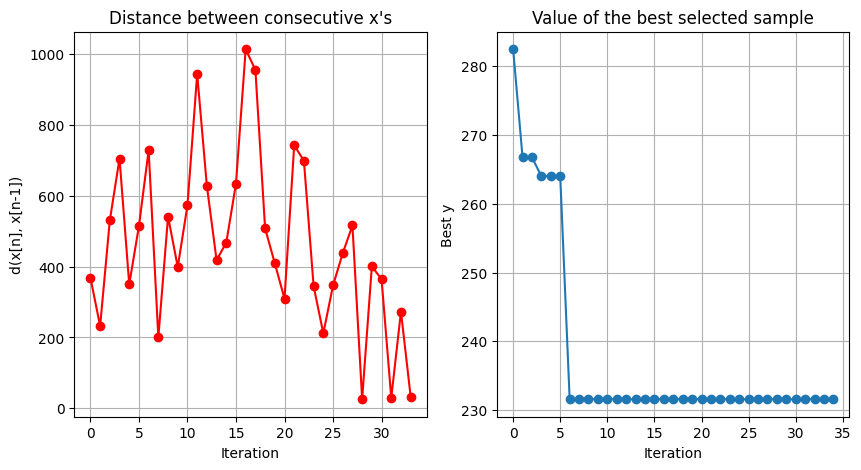

In [ ]:
b_optimization.plot_convergence()

### Hyperparameter optimization for BiLSTM model

In [ ]:
def BiLSTM_model(input_shape, num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                 dropout_rate_dense, lstm_unit, dense1_unit, dense2_unit, dense3_unit):
    inputs = Input(shape=input_shape)

    conv1 = Conv1D(num_filter, kernel_size, activation="relu")(inputs)
    pool1 = AveragePooling1D(2)(conv1)
    drop1 = Dropout(dropout_rate_conv)(pool1)

    conv2 = Conv1D(num_filter, kernel_size, activation="relu")(drop1)
    pool2 = AveragePooling1D(2)(conv2)
    drop2 = Dropout(dropout_rate_conv)(pool2)

    lstm = Bidirectional(LSTM(lstm_unit,
                               dropout=dropout_rate_lstm,
                               activation='tanh',
                               return_sequences=True,
                               kernel_regularizer=regularizers.l2(1e-4)))(drop2)
    avgpool = GlobalAveragePooling1D()(lstm)

    dense1 = Dense(dense1_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(avgpool)
    drop3 = Dropout(dropout_rate_dense)(dense1)

    dense2 = Dense(dense2_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop3)
    drop4 = Dropout(dropout_rate_dense)(dense2)

    dense3 = Dense(dense3_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop4)
    drop5 = Dropout(dropout_rate_dense)(dense3)

    output = Dense(1, activation="linear")(drop5)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [ ]:
def HPO_with_CV(args):
    learning_rate = args[0][0]
    batch_size = int(args[0][1])
    num_filter = int(args[0][2])
    kernel_size = int(args[0][3])
    dropout_rate_conv = args[0][4]
    dropout_rate_lstm = args[0][5]
    dropout_rate_dense = args[0][6]
    lstm_unit = int(args[0][7])
    dense1_unit = int(args[0][8])
    dense2_unit = int(args[0][9])
    dense3_unit = int(args[0][10])

    k_folds = 10
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1234)
    #fold_no = 1

    loss_per_fold = []

    print('Start training...')

    for train_index, val_index in kfold.split(Seq):
        X_train, X_val = Seq[train_index], Seq[val_index]
        y_train, y_val = label[train_index], label[val_index]

        model = BiLSTM_model((23,4), num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                             dropout_rate_dense, lstm_unit, dense1_unit, dense2_unit, dense3_unit)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

        #print(f'Training for fold {fold_no} ...')
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr])

        scores = model.evaluate(X_val, y_val, verbose=0)
        loss_per_fold.append(scores[1])

        #fold_no += 1

    avg_mse = np.mean(loss_per_fold)
    print('Avg validation loss:', avg_mse)
    return avg_mse


In [ ]:
lr_domain = [0.01, 0.001, 0.0001]
batch_domain = [32, 64, 128, 256, 512]
num_filter_domain = [64, 128, 256, 512]
kernel_size_domain = [3, 5]
dropout_conv_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_lstm_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_dense_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
lstm_unit_domain = [4, 8, 16, 32, 64, 128]
dense1_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense2_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense3_domain = [4, 8, 16, 32, 64, 128, 256, 512]

domain = [
    {"name": "learning_rate", "type": "discrete", "domain": lr_domain},
    {"name": "batch_size", "type": "discrete", "domain": batch_domain},
    {"name": "num_filter", "type": "discrete", "domain": num_filter_domain},
    {"name": "kernel_size", "type": "discrete", "domain": kernel_size_domain},
    {"name": "dropout_rate_conv", "type": "discrete", "domain": dropout_conv_domain},
    {"name": "dropout_rate_lstm", "type": "discrete", "domain": dropout_lstm_domain},
    {"name": "dropout_rate_dense", "type": "discrete", "domain": dropout_dense_domain},
    {"name": "lstm_unit", "type": "discrete", "domain": lstm_unit_domain},
    {"name": "dense1_domain", "type": "discrete", "domain": dense1_domain},
    {"name": "dense2_domain", "type": "discrete", "domain": dense2_domain},
    {"name": "dense3_domain", "type": "discrete", "domain": dense3_domain}
]

In [ ]:
# Initialize Bayesian optimization
b_optimization = BayesianOptimization(
    HPO_with_CV,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    verbosity=True,
    num_cores=32
)

# Run optimization
b_optimization.run_optimization(max_iter=30)

Start training...
Avg validation loss: 481.61377868652346
Start training...
Avg validation loss: 299.15155029296875
Start training...
Avg validation loss: 296.7834503173828
Start training...
Avg validation loss: 514.1168548583985
Start training...
Avg validation loss: 633.1304748535156
Start training...
Avg validation loss: 609.7879455566406
Start training...
Avg validation loss: 457.26632537841795
Start training...
Avg validation loss: 406.1358703613281
Start training...
Avg validation loss: 540.8887329101562
Start training...
Avg validation loss: 253.23907165527345
Start training...
Avg validation loss: 492.7110931396484
Start training...
Avg validation loss: 359.8610015869141
Start training...
Avg validation loss: 306.89283142089846
Start training...
Avg validation loss: 371.20311584472654
Start training...
Avg validation loss: 256.29891815185545
Start training...
Avg validation loss: 244.30353393554688
Start training...
Avg validation loss: 493.4107421875
Start training...
Avg vali

In [ ]:
b_optimization.x_opt, b_optimization.fx_opt

(array([1.00e-03, 1.28e+02, 1.28e+02, 3.00e+00, 4.00e-01, 4.00e-01,
        4.00e-01, 3.20e+01, 1.28e+02, 6.40e+01, 1.28e+02]),
 244.30353393554688)

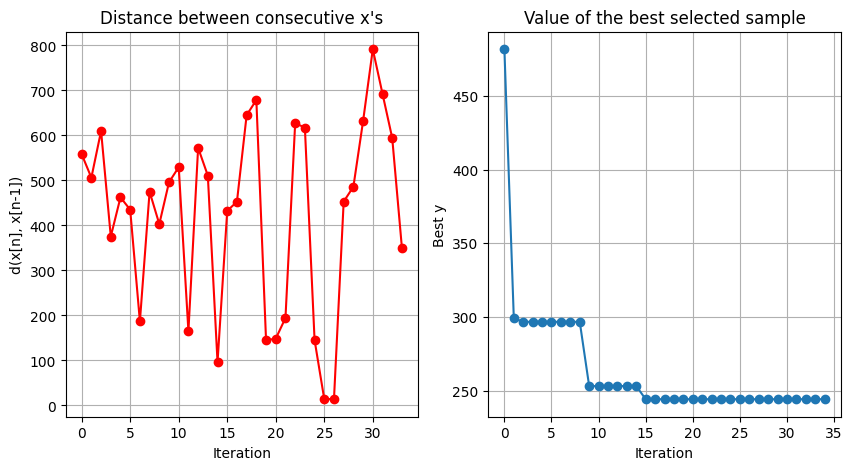

In [ ]:
b_optimization.plot_convergence()

### Hyperparameter optimization for SimpleRNN model

In [ ]:
def SimpleRNN_model(input_shape, num_filter, kernel_size, dropout_rate_conv,
                    dropout_rate_rnn, dropout_rate_dense, rnn1_unit, rnn2_unit,
                    dense1_unit, dense2_unit, dense3_unit):
    input = Input(shape=input_shape)

    conv1 = Conv1D(num_filter, kernel_size, activation="relu")(input)
    pool1 = AveragePooling1D(2)(conv1)
    drop1 = Dropout(dropout_rate_conv)(pool1)

    conv2 = Conv1D(num_filter, kernel_size, activation="relu")(drop1)
    pool2 = AveragePooling1D(2)(conv2)
    drop2 = Dropout(dropout_rate_conv)(pool2)

    srnn1 = SimpleRNN(rnn1_unit,
                      dropout=dropout_rate_rnn,
                      activation="tanh",
                      return_sequences=True,
                      kernel_regularizer=regularizers.l2(0.01))(drop2)
    srnn2 = SimpleRNN(rnn2_unit,
                      dropout=dropout_rate_rnn,
                      activation="tanh",
                      return_sequences=True,
                      kernel_regularizer=regularizers.l2(0.01))(srnn1)
    avgpool = GlobalAveragePooling1D()(srnn2)

    dense1 = Dense(dense1_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(avgpool)
    drop3 = Dropout(dropout_rate_dense)(dense1)

    dense2 = Dense(dense2_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop3)
    drop4 = Dropout(dropout_rate_dense)(dense2)

    dense3 = Dense(dense3_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop4)
    drop5 = Dropout(dropout_rate_dense)(dense3)

    output = Dense(1, activation='linear')(drop5)
    model = Model(inputs=[input], outputs=[output])

    return model

In [ ]:
def HPO_with_CV(args):
    learning_rate = args[0][0]
    batch_size = int(args[0][1])
    num_filter = int(args[0][2])
    kernel_size = int(args[0][3])
    dropout_rate_conv = args[0][4]
    dropout_rate_rnn = args[0][5]
    dropout_rate_dense = args[0][6]
    rnn1_unit = int(args[0][7])
    rnn2_unit = int(args[0][8])
    dense1_unit = int(args[0][9])
    dense2_unit = int(args[0][10])
    dense3_unit = int(args[0][11])

    k_folds = 10
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1234)
    #fold_no = 1

    loss_per_fold = []

    print('Start training...')

    for train_index, val_index in kfold.split(Seq):
        X_train, X_val = Seq[train_index], Seq[val_index]
        y_train, y_val = label[train_index], label[val_index]

        model = SimpleRNN_model((23,4), num_filter, kernel_size, dropout_rate_conv,
                                dropout_rate_rnn, dropout_rate_dense, rnn1_unit, rnn2_unit,
                                dense1_unit, dense2_unit, dense3_unit)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

        #print(f'Training for fold {fold_no} ...')
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr])

        scores = model.evaluate(X_val, y_val, verbose=0)
        loss_per_fold.append(scores[1])

        #fold_no += 1

    avg_mse = np.mean(loss_per_fold)
    print('Avg validation loss:', avg_mse)
    return avg_mse


In [ ]:
lr_domain = [0.01, 0.001, 0.0001]
batch_domain = [32, 64, 128, 256, 512]
num_filter_domain = [64, 128, 256, 512]
kernel_size_domain = [3, 5]
dropout_conv_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_rnn_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_dense_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
rnn1_unit_domain = [4, 8, 16, 32, 64, 128]
rnn2_unit_domain = [4, 8, 16, 32, 64, 128]
dense1_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense2_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense3_domain = [4, 8, 16, 32, 64, 128, 256, 512]

domain = [
    {"name": "learning_rate", "type": "discrete", "domain": lr_domain},
    {"name": "batch_size", "type": "discrete", "domain": batch_domain},
    {"name": "num_filter", "type": "discrete", "domain": num_filter_domain},
    {"name": "kernel_size", "type": "discrete", "domain": kernel_size_domain},
    {"name": "dropout_rate_conv", "type": "discrete", "domain": dropout_conv_domain},
    {"name": "dropout_rate_rnn", "type": "discrete", "domain": dropout_rnn_domain},
    {"name": "dropout_rate_dense", "type": "discrete", "domain": dropout_dense_domain},
    {"name": "rnn1_unit", "type": "discrete", "domain": rnn1_unit_domain},
    {"name": "rnn2_unit", "type": "discrete", "domain": rnn2_unit_domain},
    {"name": "dense1_domain", "type": "discrete", "domain": dense1_domain},
    {"name": "dense2_domain", "type": "discrete", "domain": dense2_domain},
    {"name": "dense3_domain", "type": "discrete", "domain": dense3_domain}
]

In [ ]:
# Initialize Bayesian optimization
b_optimization = BayesianOptimization(
    HPO_with_CV,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    verbosity=True,
    num_cores=32
)

# Run optimization
b_optimization.run_optimization(max_iter=30)

Start training...
Avg validation loss: 336.10970306396484
Start training...
Avg validation loss: 540.6248657226563
Start training...
Avg validation loss: 269.7749359130859
Start training...
Avg validation loss: 367.81043701171876
Start training...
Avg validation loss: 462.8844757080078
Start training...
Avg validation loss: 271.0332916259766
Start training...
Avg validation loss: 416.51080627441405
Start training...
Avg validation loss: 445.58278503417966
Start training...
Avg validation loss: 482.78733215332034
Start training...
Avg validation loss: 295.5047088623047
Start training...
Avg validation loss: 351.30626220703124
Start training...
Avg validation loss: 475.7580169677734
Start training...
Avg validation loss: 238.2679443359375
Start training...
Avg validation loss: 517.8626953125
Start training...
Avg validation loss: 504.5520355224609
Start training...
Avg validation loss: 456.97267150878906
Start training...
Avg validation loss: 528.1737762451172
Start training...
Avg valid

In [ ]:
b_optimization.x_opt, b_optimization.fx_opt

(array([1.00e-03, 1.28e+02, 6.40e+01, 3.00e+00, 1.00e-01, 3.00e-01,
        1.00e-01, 6.40e+01, 1.28e+02, 5.12e+02, 1.28e+02, 2.56e+02]),
 231.84925384521483)

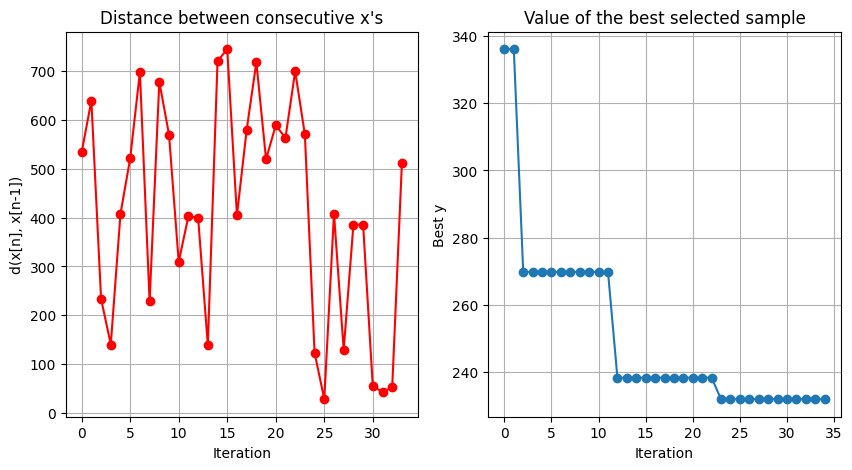

In [ ]:
b_optimization.plot_convergence()

### Hyperparameter optimization for Attention model

In [ ]:
class PositionalEncoding(Layer):
    def __init__(self, sequence_len=None, embedding_dim=None,**kwargs):
        super(PositionalEncoding, self).__init__()
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim

    def call(self, x):

        position_embedding = np.array([
            [pos / np.power(10000, 2. * i / self.embedding_dim) for i in range(self.embedding_dim)]
            for pos in range(self.sequence_len)])

        position_embedding[:, 0::2] = np.sin(position_embedding[:, 0::2])  # dim 2i
        position_embedding[:, 1::2] = np.cos(position_embedding[:, 1::2])  # dim 2i+1
        position_embedding = tf.cast(position_embedding, dtype=tf.float32)

        return position_embedding+x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'sequence_len' : self.sequence_len,
            'embedding_dim' : self.embedding_dim,
        })
        return config

def MultiHeadAttention_model(input_shape, num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                             dropout_rate_dense, dropout_rate_attention, lstm_unit,
                             num_heads, key_dim, dense1_unit, dense2_unit, dense3_unit):
    input = Input(shape=input_shape)

    conv1 = Conv1D(num_filter, kernel_size, activation="relu")(input)
    pool1 = AveragePooling1D(2)(conv1)
    drop1 = Dropout(dropout_rate_conv)(pool1)

    conv2 = Conv1D(num_filter, kernel_size, activation="relu")(drop1)
    pool2 = AveragePooling1D(2)(conv2)
    drop2 = Dropout(dropout_rate_conv)(pool2)

    lstm = Bidirectional(LSTM(lstm_unit,
                               dropout=dropout_rate_lstm,
                               activation='tanh',
                               return_sequences=True,
                               kernel_regularizer=regularizers.l2(0.01)))(drop2)

    pos_embedding = PositionalEncoding(sequence_len=int(((23-kernel_size+1)/2-kernel_size+1)/2), embedding_dim=2*lstm_unit)(lstm)
    atten = MultiHeadAttention(num_heads=num_heads,
                               key_dim=key_dim,
                               dropout=dropout_rate_attention,
                               kernel_regularizer=regularizers.l2(0.01))(pos_embedding, pos_embedding)

    flat = Flatten()(atten)

    dense1 = Dense(dense1_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(flat)
    drop3 = Dropout(dropout_rate_dense)(dense1)

    dense2 = Dense(dense2_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop3)
    drop4 = Dropout(dropout_rate_dense)(dense2)

    dense3 = Dense(dense3_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop4)
    drop5 = Dropout(dropout_rate_dense)(dense3)

    output = Dense(1, activation="linear")(drop5)

    model = Model(inputs=[input], outputs=[output])
    return model

In [ ]:
def HPO_with_CV(args):
    learning_rate = args[0][0]
    batch_size = int(args[0][1])
    num_filter = int(args[0][2])
    kernel_size = int(args[0][3])
    dropout_rate_conv = args[0][4]
    dropout_rate_lstm = args[0][5]
    dropout_rate_dense = args[0][6]
    dropout_rate_attention = args[0][7]
    lstm_unit = int(args[0][8])
    num_heads = int(args[0][9])
    key_dim = int(args[0][10])
    dense1_unit = int(args[0][11])
    dense2_unit = int(args[0][12])
    dense3_unit = int(args[0][13])

    k_folds = 10
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1234)
    #fold_no = 1

    loss_per_fold = []
    #print(f'learning_rate:{learning_rate}\tbatch_size:{batch_size}\tnum_filter:{num_filter}\tkernel_size:{kernel_size}\tdropout_rate:{dropout_rate}\tlstm_unit:{lstm_unit}\tnum_heads:{num_heads}\tkey_dim:{key_dim}\tdense1_unit:{dense1_unit}\tdense2_unit:{dense2_unit}\tdense3_unit:{dense3_unit}')
    print('Start training...')

    for train_index, val_index in kfold.split(Seq):
        X_train, X_val = Seq[train_index], Seq[val_index]
        y_train, y_val = label[train_index], label[val_index]

        model = MultiHeadAttention_model((23,4), num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                                         dropout_rate_dense, dropout_rate_attention, lstm_unit, num_heads,
                                         key_dim, dense1_unit, dense2_unit, dense3_unit)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

        #print(f'Training for fold {fold_no} ...')
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr])

        scores = model.evaluate(X_val, y_val, verbose=0)
        loss_per_fold.append(scores[1])

        #fold_no += 1

    avg_mse = np.mean(loss_per_fold)
    print('Avg validation MSE:', avg_mse)
    return avg_mse


In [ ]:
lr_domain = [0.01, 0.001, 0.0001]
batch_domain = [32, 64, 128, 256, 512]
num_filter_domain = [64, 128, 256, 512]
kernel_size_domain = [3, 5]
dropout_conv_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_lstm_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_dense_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_attention_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
lstm_unit_domain = [4, 8, 16, 32, 64, 128]
num_heads_domain = [2, 4, 6]
key_dim_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense1_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense2_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense3_domain = [4, 8, 16, 32, 64, 128, 256, 512]

domain = [
    {"name": "learning_rate", "type": "discrete", "domain": lr_domain},
    {"name": "batch_size", "type": "discrete", "domain": batch_domain},
    {"name": "num_filter", "type": "discrete", "domain": num_filter_domain},
    {"name": "kernel_size", "type": "discrete", "domain": kernel_size_domain},
    {"name": "dropout_rate_conv", "type": "discrete", "domain": dropout_conv_domain},
    {"name": "dropout_rate_lstm", "type": "discrete", "domain": dropout_lstm_domain},
    {"name": "dropout_rate_dense", "type": "discrete", "domain": dropout_dense_domain},
    {"name": "dropout_rate_attention", "type": "discrete", "domain": dropout_attention_domain},
    {"name": "lstm_unit", "type": "discrete", "domain": lstm_unit_domain},
    {"name": "num_heads", "type": "discrete", "domain": num_heads_domain},
    {"name": "key_dim", "type": "discrete", "domain": key_dim_domain},
    {"name": "dense1_domain", "type": "discrete", "domain": dense1_domain},
    {"name": "dense2_domain", "type": "discrete", "domain": dense2_domain},
    {"name": "dense3_domain", "type": "discrete", "domain": dense3_domain}
]

In [ ]:
# Initialize Bayesian optimization
b_optimization = BayesianOptimization(
    HPO_with_CV,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    verbosity=True,
    num_cores=32
)

# Run optimization
b_optimization.run_optimization(max_iter=30)

Start training...
Avg validation MSE: 513.7668334960938
Start training...
Avg validation MSE: 348.303857421875
Start training...
Avg validation MSE: 600.1477600097656
Start training...
Avg validation MSE: 684.5880279541016
Start training...
Avg validation MSE: 357.59739990234374
Start training...
Avg validation MSE: 616.8988098144531
Start training...
Avg validation MSE: 252.97876892089843
Start training...
Avg validation MSE: 487.68675842285154
Start training...
Avg validation MSE: 540.8086181640625
Start training...
Avg validation MSE: 807.0864227294921
Start training...
Avg validation MSE: 348.23541870117185
Start training...
Avg validation MSE: 487.5905792236328
Start training...
Avg validation MSE: 478.9941101074219
Start training...
Avg validation MSE: 293.2437255859375
Start training...
Avg validation MSE: 577.3435302734375
Start training...
Avg validation MSE: 595.2872863769531
Start training...
Avg validation MSE: 301.12806243896483
Start training...
Avg validation MSE: 306.66

In [ ]:
b_optimization.x_opt, b_optimization.fx_opt

(array([1.00e-03, 6.40e+01, 2.56e+02, 3.00e+00, 4.00e-01, 5.00e-01,
        1.00e-01, 2.00e-01, 1.28e+02, 2.00e+00, 6.40e+01, 5.12e+02,
        1.28e+02, 2.56e+02]),
 233.7442398071289)

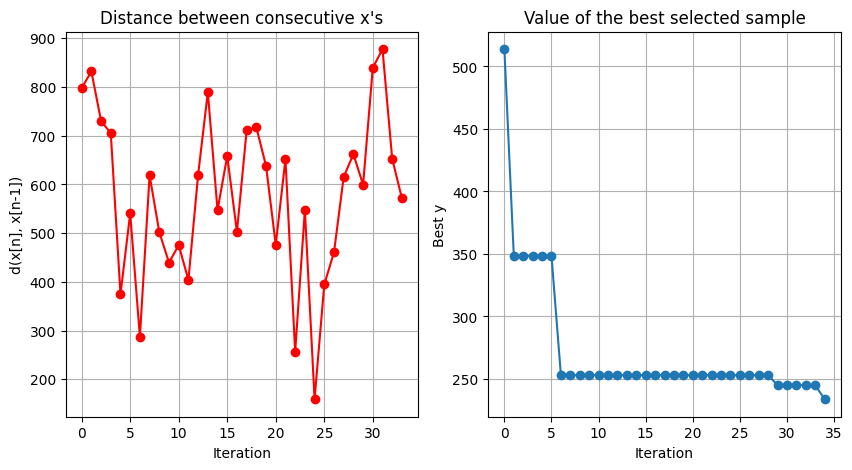

In [ ]:
b_optimization.plot_convergence()